# Hierarchical clustering based on estimated N400 amplitude

In [1]:
from warnings import warn

# Import Python modules for data analysis and plotting
import pandas as pd
import progressbar
import numpy as np
from scipy.stats import t as tdist

from matplotlib import pyplot as plt
%matplotlib inline

# Modules for hierarchical clustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Bring in a bridge to R for statistics
from rpy2 import robjects as r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# R-packages
importr('lme4')
importr('lmerTest')

# The R code produces some harmless warnings that clutter up the page.
# This disables printing of the warnings. When modifying this notebook, you may want to turn
# this back on.
import warnings
warnings.filterwarnings('ignore')

# For pretty display of tables
from IPython.display import display

In [2]:
# Load the data
data = pd.read_csv('data.csv', index_col=['subject', 'cue-english', 'association-english'])

# Show the first 10 rows
display(data.head(10))

# Compute the list of stimuli and subjects
subjects = data.index.levels[0]
n_subjects = len(subjects)
stimuli = data.index.levels[2]
n_stimuli = len(stimuli)

cue association language  \
subject   cue-english association-english                                 
subject01 zebra       couch                  zebra       zetel       NL   
          couch       hippopotamus           zetel   nijlpaard       NL   
          giraffe     closet                 giraf        kast       NL   
          desk        tiger                 bureau      tijger       NL   
          table       rhinoceros             tafel   neushoorn       NL   
          elephant    couch                olifant       zetel       NL   
          zebra       lion                   zebra       leeuw       NL   
          chair       tiger                  stoel      tijger       NL   
          lion        door                   leeuw        deur       NL   
          desk        elephant              bureau     olifant       NL   

                                           button      N400  
subject   cue-english association-english                    
subject01 zebra       couch                     1  0.043147  
          couch       hippopotamus              1 -0.725864  
          giraffe     closet                    1  0.252211  
          desk        tiger                     1  0.563608  
          table       rhinoceros                1 -0.765238  
          elephant    couch                     1  0.041667  
          zebra       lion                      0 -0.530273  
          chair       tiger                     1  0.189504  
          lion        door                      1  1.515943  
          desk        elephant                  1  1.090760

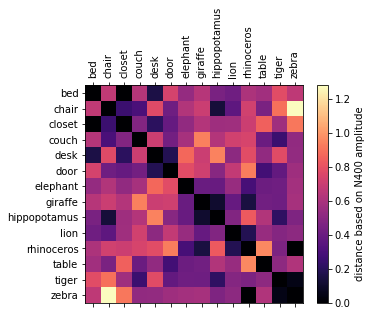

In [3]:
# Compute the full word2word distance matrix for each subject
distance = np.zeros((n_stimuli, n_stimuli, n_subjects))

for i, subject in enumerate(subjects):
    data_subject = data.xs(subject, level='subject')
    for cue, association in data_subject.index.values:
        cue_ind, association_ind = stimuli.get_loc(cue), stimuli.get_loc(association)
        
        # The distance between words A and B is the N400 amplitude during the trial where
        # word A was the cue and word B was the association word.
        distance[cue_ind, association_ind, i] = data_subject.loc[(cue, association)]['N400']

# Remove the mean along the columns
for x in range(distance.shape[0]):
    distance[:, x] -= np.nanmean(np.vstack((distance[:x, x, :], distance[x+1:, x, :])), axis=0)
for x in range(distance.shape[-1]):
    np.fill_diagonal(distance[..., x], 0)

# Average across the subjects
mean_distance = distance.mean(axis=2)

# Make positive and symmetric
mean_distance = (mean_distance + mean_distance.T) / 2.
mean_distance -= np.min(mean_distance)

# The distance from a word to itself is 0
np.fill_diagonal(mean_distance, 0)

# Plot the result
plt.figure(figsize=(5, 4))
plt.matshow(mean_distance, cmap='magma', fignum=0)
plt.xticks(np.arange(n_stimuli), stimuli, rotation=90)
plt.yticks(np.arange(n_stimuli), stimuli);
cb = plt.colorbar()
cb.set_label('distance based on N400 amplitude')

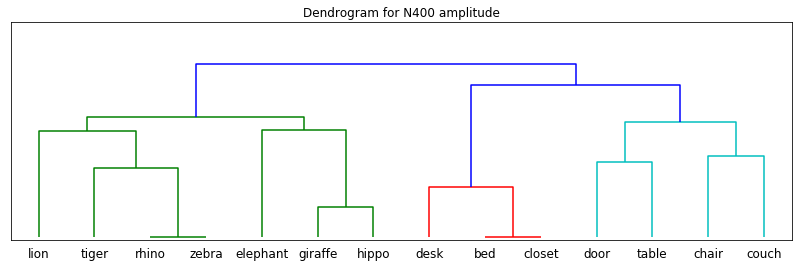

In [4]:
# Perform hierarchical clustering
dist = squareform(mean_distance)
Z = linkage(dist, 'average')

# For display, abbreviate hippopotamus and rhinoceros
stimuli_abbr = ['hippo' if s == 'hippopotamus' else s for s in stimuli]
stimuli_abbr = ['rhino' if s == 'rhinoceros' else s for s in stimuli_abbr]

plt.figure(figsize=(14, 4))
d = dendrogram(Z, labels=stimuli_abbr)
#annotate_dendrogram(all_labels, Z, d, stimuli, col='N400')
plt.ylim(-0.01, 0.8)
plt.title('Dendrogram for N400 amplitude')
plt.yticks([])
plt.grid(False)

In [5]:
def group(data, group1, group2):
    """Assigns 'between' or 'within' cluster labels to each cue-association pair"""
    labels = []
    for cue, association in zip(data.index.get_level_values(level='cue-english'),
                                data.index.get_level_values(level='association-english')):
        if ((cue in group1 and association in group1) or
            (cue in group2 and association in group2)):
            labels.append('within')
        elif ((cue in group1 and association in group2) or
              (cue in group2 and association in group1)):
            labels.append('between')
        else:
            labels.append(np.NaN)
    data_ = data.copy()
    data_['label'] = labels
    
    # Drop all rows that were neither within-cluster or between-cluster
    data_ = data_.dropna()
    
    return data_

def lme_test(group1, group2, data):
    """Performs a statistical test using an LME model to obtain a p-value for
    'between' and 'within' cluster values
    """
    # We can only do a test if the group sizes are both > 1
    if len(group1) == 1 or len(group2) == 1:
        return ''
    
    # Annotate data with between-cluster and within-cluster labels
    data = group(data, group1, group2)
    
    # Send the data to R
    r.globalenv['data'] = data.reset_index()
    
    # Fit the LME model.
    # Fit random slopes and intercepts for subjects.
    r.r('m = lmer(N400 ~ label + (label | subject), data=data)')
    try:
        df, t, p = r.r('summary(m)$coefficients["labelwithin", 3:5]')
    except:
        # Estimation of degress of freedom failed. Take n_subjects - 1 as ddof
        print('Estimation of degrees of freedom failed for cluster (%s-%s)' % (group1, group2))
        t = r.r('summary(m)$coefficients["labelwithin", "t value"]')[0]
        n_subjects = len(data.index.levels[0])
        df = n_subjects - 1
        p = tdist.sf(np.abs(t), df)
    
    # Bonferroni correction for p values
    p *= 4  # There are 4 clusters we can test in this dataset
    
    # Construct a text label with the results
    if p < 0.001:
        return 't(%d)=%.3f\np<0.001' % (df, t)
    else:
        return 't(%d)=%.3f\np=%.3f' % (df, t, p)

Estimation of degrees of freedom failed for cluster (['lion', 'tiger', 'rhinoceros', 'zebra']-['elephant', 'giraffe', 'hippopotamus'])
Estimation of degrees of freedom failed for cluster (['lion', 'tiger', 'rhinoceros', 'zebra', 'elephant', 'giraffe', 'hippopotamus']-['desk', 'bed', 'closet', 'door', 'table', 'chair', 'couch'])


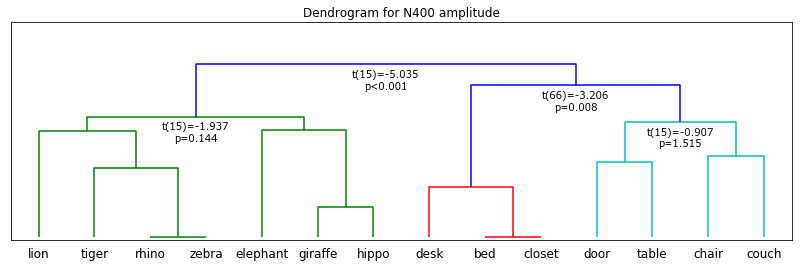

In [6]:
from annotate_dendrogram import annotate_dendrogram
plt.figure(figsize=(14, 4))
d = dendrogram(Z, labels=stimuli_abbr)
annotate_dendrogram(Z, d, stimuli, lme_test, args=[data])
plt.ylim(-0.01, 0.8)
plt.title('Dendrogram for N400 amplitude')
plt.yticks([])
plt.grid(False)